# Gap Overlap Eye-Tracking Data Pre-processing

This notebook performs comprehensive pre-processing of eye-tracking data from the Gap Overlap task, including:
- Trial validity assessment
- Participant exclusion criteria
- Eye-tracker calibration quality analysis
- Demographic summaries of excluded participants

In [82]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mne
from mne.datasets.eyelink import data_path
from mne.preprocessing.eyetracking import read_eyelink_calibration
from mne.viz.eyetracking import plot_gaze



In [83]:
# Date 
date ="2025_06_27"

## Configuration Parameters

Set the key parameters for preprocessing analysis.

In [84]:
# Papermill parameters
date = "2025_06_27"
min_n_trials_per_condition = 6

In [85]:

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc


## Create Word Document for Preprocessing Results

This section initializes a Word document to capture all preprocessing results and statistics.

In [86]:

# Create a document

doc = docx.Document()

# Title page
section = doc.sections[0]
#section.start_type = WD_SECTION.ODD_PAGE
#section.orientation = WD_ORIENT.LANDSCAPE
#section.page_width, section.page_height = section.page_height, section.page_width

title = doc.add_paragraph()
title_run = title.add_run("Gap Overlap preprocessing results")
title_run.bold = True
title_run.font.size = Pt(28)
title_run.font.name = 'Arial'
title.alignment = WD_ALIGN_PARAGRAPH.CENTER

doc.add_paragraph("")
doc.add_paragraph(f"Date: {date}").alignment = WD_ALIGN_PARAGRAPH.CENTER
doc.add_paragraph("Author: Gabriel Blanco").alignment = WD_ALIGN_PARAGRAPH.CENTER
doc.add_page_break()

# Add new doc section with landscape orientation
section = doc.add_section()
section.start_type = WD_SECTION.ODD_PAGE
new_width, new_height = section.page_height, section.page_width
section.orientation = WD_ORIENT.LANDSCAPE
section.page_width = new_width


doc.add_heading(f"Data pre-processings results", 0)

doc.add_heading('Invalid Trial Criteria', level=1)
doc.add_paragraph(
    "A trial is considered invalid if it meets any of the following criteria:\n\n"
    "1. Did not look at fixation point for at least 500 ms\n"
    "   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.\n\n"
    "2. Reaction time (RT) to peripheral target is greater than 1200 ms\n"
    "   - The participant took too long to respond, indicating possible distraction or inattention.\n\n"
    "3. Reaction time (RT) is less than 100 ms\n"
    "   - Extremely fast responses are likely anticipatory and not genuine reactions.\n\n"
    "4. Gaze directed to the wrong side of the screen\n"
    "   - The participant looked away from the intended target, indicating an incorrect response.\n\n"
    "5. Minimum number of trials\n"
    "   - The participant must have a minimum of 6 valid trials per condition in order to not be removed.\n\n"
    "Note:\n"
    "These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. "
    "Excluding invalid trials improves the reliability of behavioral and statistical results. "
    "Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files"
)


## Data loading

In [87]:
# Load et file
go_df= pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv")
go_df        

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult


In [88]:
# Load subjects removed file
subjects_removed_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv")
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [89]:
# Print totl number of subjects and removed subjects
print(f"Total number of subjects: {len(go_df['subject'].unique())}")
print(f"Number of subjects removed: {len(subjects_removed_df['subject'].unique())}")

Total number of subjects: 230
Number of subjects removed: 12


## Calculate valid and invalid trials

## Invalid Trial Criteria

A trial is considered **invalid** if it meets any of the following criteria:

1. **Did not look at fixation point for at least 500 ms**  
   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.

2. **Reaction time (RT) to peripheral target is greater than 1200 ms**  
   - The participant took too long to respond, indicating possible distraction or inattention.

3. **Reaction time (RT) is less than 100 ms**  
   - Extremely fast responses are likely anticipatory and not genuine reactions.

4. **Gaze directed to the wrong side of the screen**  
   - The participant looked away from the intended target, indicating an incorrect response.

5. **Minimum number of trials**
   - The participant must have a minimum of 6 valid trials per condition in order to not be removed

> **Note:**  
> These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. Excluding invalid trials improves the reliability of behavioral and statistical results. Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files


### Remove Trials with Negative Reaction Times

Trials with negative reaction times are considered invalid and will be excluded from analysis.

In [90]:
# Change reaction times below 0 to invalid trials 

# Print total number of trials that were removed
print(f"Total number of trials with negative RT: {len(go_df[go_df.rt < 0])}")
go_df.loc[go_df.rt < 0, "valid_trials"] = False

# Print total trials above 1200ms
print(f"Total number of trials with RT above 1200ms: {len(go_df[go_df.rt > 1200])}")

# Convert invalid trial's rt into np.nan values
go_df.loc[go_df.valid_trials == False, "rt"] = np.nan

Total number of trials with negative RT: 725
Total number of trials with RT above 1200ms: 186


### Additional Quality Checks

Perform additional quality checks on reaction time data.

In [91]:
# Check for extremely slow or fast reaction times beyond the initial criteria
print("REACTION TIME QUALITY CHECKS")

# Check for trials with RT between 0-100ms (anticipatory responses)
anticipatory_trials = go_df[(go_df.rt < 0) & (go_df.rt < 100) & (go_df.valid_trials == True)]
print(f"Trials with anticipatory RT (0-100ms): {len(anticipatory_trials)}")

# Mark anticipatory trials as invalid
if len(anticipatory_trials) > 0:
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "valid_trials"] = False
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "rt"] = np.nan
    print("Anticipatory trials marked as invalid")

# Check for extremely slow responses (> 1200ms)
slow_trials = go_df[(go_df.rt > 1200) & (go_df.valid_trials == True)]
print(f"Trials with slow RT (>1200ms): {len(slow_trials)}")

# Mark slow trials as invalid
if len(slow_trials) > 0:
    go_df.loc[go_df.rt > 1200, "valid_trials"] = False
    go_df.loc[go_df.rt > 1200, "rt"] = np.nan
    print("Slow trials marked as invalid")



REACTION TIME QUALITY CHECKS
Trials with anticipatory RT (0-100ms): 0
Trials with slow RT (>1200ms): 0


### Participant Statistics for Trial Validity

Calculate trial validity statistics for each participant across all conditions.

In [92]:
# Calculate the overall number of trials and failed trials per subject into one dataframe
total_trials = go_df.groupby(["subject", "ndd"]).size().reset_index(name="total_trials")
failed_trials = go_df[go_df.valid_trials == False].groupby(["subject"]).size().reset_index(name="failed_trials")

# Calculate the number of failed "Overlap" trials
total_overlap = go_df[go_df.condition == "Overlap"].groupby(["subject"]).size().reset_index(name="total_overlap")
failed_overlap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Overlap")].groupby(["subject"]).size().reset_index(name="failed_overlap")

# Calculate the number of failed "Baseline" trials
total_baseline = go_df[go_df.condition == "Baseline"].groupby(["subject"]).size().reset_index(name="total_baseline")
failed_baseline = go_df[(go_df.valid_trials == False) & (go_df.condition == "Baseline")].groupby(["subject"]).size().reset_index(name="failed_baseline")

# Calculate the number of failed "Gap" trials
total_gap = go_df[go_df.condition == "Gap"].groupby(["subject"]).size().reset_index(name="total_gap")
failed_gap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Gap")].groupby(["subject"]).size().reset_index(name="failed_gap")

# Merge all dataframes
trial_data = pd.merge(total_trials, failed_trials, on="subject", how="left")
trial_data = pd.merge(trial_data, total_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, total_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, total_gap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_gap, on="subject", how="left")

# Fill NaN values with 0
trial_data = trial_data.fillna(0)

# Percentage of failed trials
trial_data["failed_trials"] = trial_data["failed_trials"].fillna(0)
trial_data["%_failed"] = trial_data["failed_trials"] / trial_data["total_trials"] * 100

# Percentage of failed "Baseline" trials
trial_data["%_baseline"] = trial_data["failed_baseline"] / trial_data["total_baseline"] * 100

# Percentage of failed "Overlap" trials
trial_data["%_overlap"] = trial_data["failed_overlap"] / trial_data["total_overlap"] * 100

# Percentage of failed "Gap" trials
trial_data["%_gap"] = trial_data["failed_gap"] / trial_data["total_gap"] * 100

# Total valid trials 
trial_data["valid_trials"] = trial_data["total_trials"] - trial_data["failed_trials"]

# Total valid Baseline trials
trial_data["valid_baseline"] = trial_data["total_baseline"] - trial_data["failed_baseline"]

# Total valid Overlap trials
trial_data["valid_overlap"] = trial_data["total_overlap"] - trial_data["failed_overlap"]

# Total valid Gap trials
trial_data["valid_gap"] = trial_data["total_gap"] - trial_data["failed_gap"]

# Create column to highlight participants who have at least minimum valid trials in all conditions
trial_data["valid_trials_all_conditions"] = (
    (trial_data["valid_baseline"] >= min_n_trials_per_condition) &
    (trial_data["valid_overlap"] >= min_n_trials_per_condition) &
    (trial_data["valid_gap"] >= min_n_trials_per_condition)
)

# Keep only important columns
trial_data = trial_data[["subject", "ndd", "total_trials", "failed_trials", "%_failed", "total_overlap", "%_overlap", "total_baseline", "%_baseline", "total_gap", "%_gap", 
"valid_trials", "valid_baseline", "valid_overlap", "valid_gap", "valid_trials_all_conditions"]]

In [93]:
trial_data

,subject,ndd,total_trials,failed_trials,%_failed,total_overlap,%_overlap,total_baseline,%_baseline,total_gap,%_gap,valid_trials,valid_baseline,valid_overlap,valid_gap,valid_trials_all_conditions
0,002Z,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
1,0042P,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True
2,0043F1,no_ndd,36,0.0,0.000000,12.0,0.000000,12.0,0.000000,12.0,0.000000,36.0,12.0,12.0,12.0,True
3,0050M1,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
4,0050P,ndd,44,11.0,25.000000,12.0,8.333333,16.0,31.250000,16.0,31.250000,33.0,11.0,11.0,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1226P,ndd,30,15.0,50.000000,12.0,66.666667,4.0,25.000000,14.0,42.857143,15.0,3.0,4.0,8.0,False
226,1256F1,ndd,38,3.0,7.894737,12.0,0.000000,14.0,14.285714,12.0,8.333333,35.0,12.0,12.0,11.0,True
227,1256P,ndd,39,10.0,25.641026,13.0,46.153846,12.0,0.000000,14.0,28.571429,29.0,12.0,7.0,10.0,True
228,1256S1,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True


In [94]:
# Add the trial data to the document
doc.add_heading('Valid Trial Analysis', level=1)

# Add bullet point for total number of participants 
doc.add_paragraph(f"Total number of participants: {len(trial_data['subject'].unique())}", style='ListBullet')

print(f"Total number of participants: {len(trial_data['subject'].unique())}")

# Add total number of participants with the min number of trials
doc.add_paragraph(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}", style='ListBullet')
print(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}")

Total number of participants: 230
Total number of participants with at least 6 valid trials in all conditions: 209


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [95]:
# Add the subjects without min number of trial criteria to subjects_removed_df
missing_ids = trial_data[trial_data["valid_trials_all_conditions"] == False][["subject"]].copy()
# Add the subjects without min number of trial criteria to subjects_removed_df and add reasons as 'not enough trials'
missing_ids["status"] = f"not enough trials ({min_n_trials_per_condition})"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)


In [96]:
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [97]:
## Calculate and describe the properties of invalid trials
# Check the proportion of overlap, baseline and gap in the number of invalid trials
doc.add_heading('Proportion of Invalid Trials', level=1)
# Calculate the proportion of invalid trials for each condition
proportion_invalid = trial_data[["subject", "ndd", "%_overlap", "%_baseline", "%_gap"]].copy()

# Describe proportion_invalid by calculating the mean for only the dropped subjects
proportion_invalid = proportion_invalid[proportion_invalid["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid = proportion_invalid.groupby("ndd").agg(
    mean_overlap=("%_overlap", "mean"),
    mean_baseline=("%_baseline", "mean"),
    mean_gap=("%_gap", "mean"),
).reset_index()
proportion_invalid = proportion_invalid.round(2)

# Add another column for the sum of total trials for each category only for those that were dropped
trial_data_dropped = trial_data[trial_data["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid["sum_overlap"] = trial_data_dropped.groupby("ndd")["total_overlap"].sum().values
proportion_invalid["sum_baseline"] = trial_data_dropped.groupby("ndd")["total_baseline"].sum().values
proportion_invalid["sum_gap"] = trial_data_dropped.groupby("ndd")["total_gap"].sum().values

# Change column names to improve clarity
proportion_invalid.rename(
    columns={
        "ndd": "NDD Group",
        "mean_overlap": "Mean % Overlap Invalid Trials",
        "mean_baseline": "Mean % Baseline Invalid Trials",
        "mean_gap": "Mean % Gap Invalid Trials"
    },
    inplace=True,
)

# Add the proportion of invalid trials to the document
doc.add_heading('Description of Invalid Trial Data', level=3)
doc = df_to_table(doc, proportion_invalid)

proportion_invalid

,NDD Group,Mean % Overlap Invalid Trials,Mean % Baseline Invalid Trials,Mean % Gap Invalid Trials,sum_overlap,sum_baseline,sum_gap
0,ndd,62.02,57.12,67.99,107.0,111.0,119.0
1,no_ndd,69.05,57.56,52.95,34.0,60.0,38.0


### Check Participant's Eye-Tracker Calibration Quality

Analyze calibration quality for each participant to identify those with poor calibration that should be excluded from analysis.

Processing subject: 0042P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0042P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0042P_GO.asc


Number of calibrations for subject 0042P: 1
Processing subject: 0043F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0043F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0043F1_GO.asc
Number of calibrations for subject 0043F1: 1
Processing subject: 0050M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0050M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0050M1_GO.asc
Number of calibrations for subject 0050M1: 1
Processing subject: 0050P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0050P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_fil

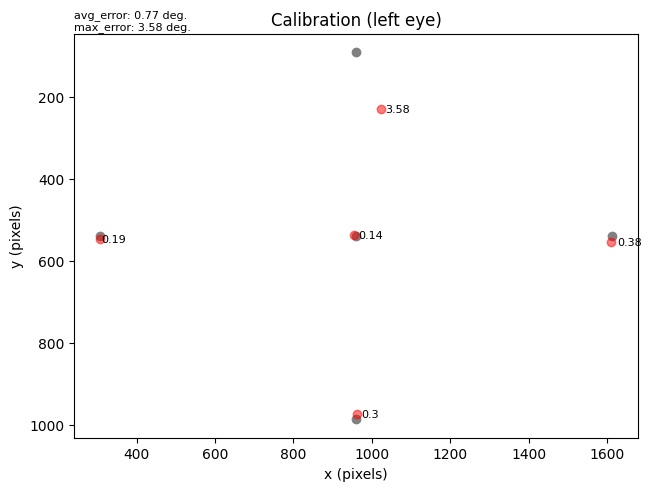

Processing subject: 0083M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0083M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0083M1_GO.asc
Number of calibrations for subject 0083M1: 1
Processing subject: 0083P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0083P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0083P_GO.asc
Number of calibrations for subject 0083P: 1
Processing subject: 0086F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0086F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0086F1_GO.asc
Number of calibrations for su

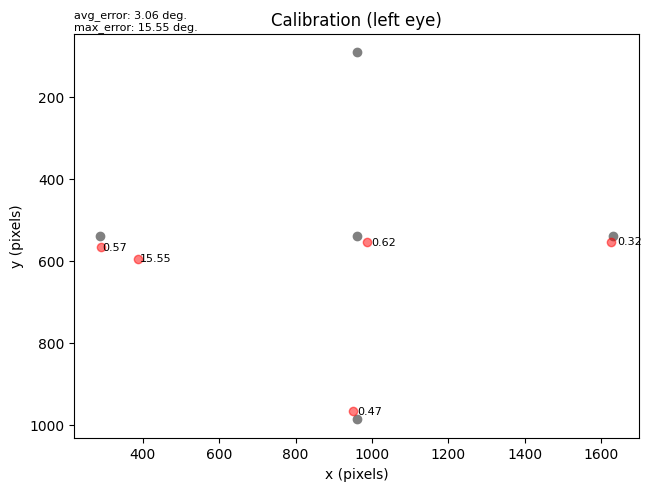

Processing subject: 0183M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0183M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0183M1_GO.asc
Number of calibrations for subject 0183M1: 1
Processing subject: 0183P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0183P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0183P_GO.asc
Number of calibrations for subject 0183P: 1
Processing subject: 0183S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0183S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0183S1_GO.asc
Number of calibrations for su

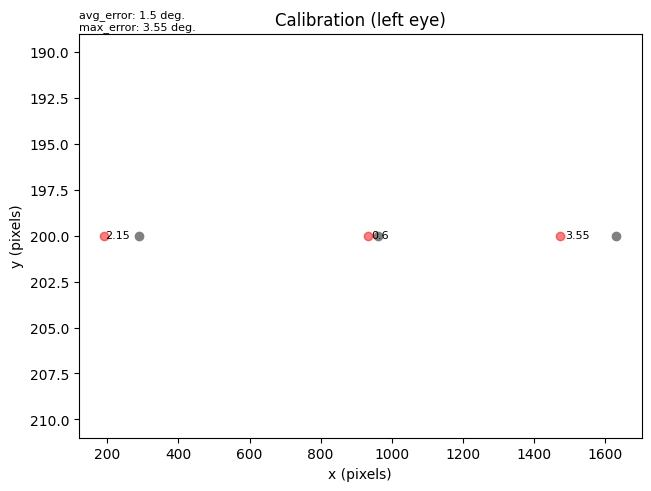

Processing subject: 0275F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0275F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0275F1_GO.asc
Number of calibrations for subject 0275F1: 1
Processing subject: 0275P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0275P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0275P_GO.asc
Number of calibrations for subject 0275P: 2
Multiple calibrations found for subject 0275P. Using the last one.
Processing subject: 0281M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\0281M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\so

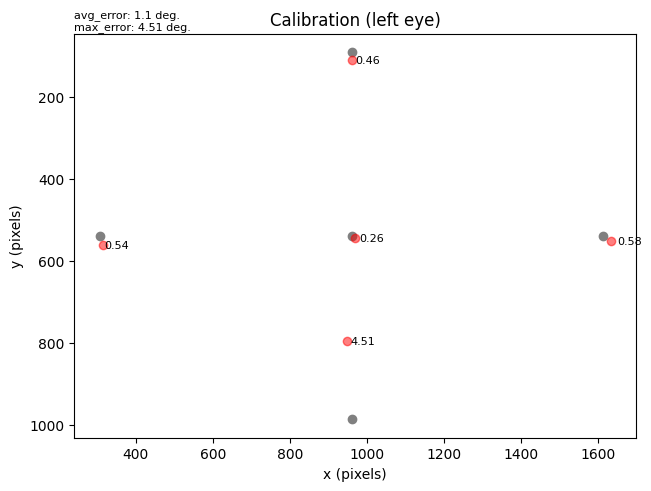

Processing subject: 1009M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1009M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1009M1_GO.asc
Number of calibrations for subject 1009M1: 1
Processing subject: 1009P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1009P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1009P_GO.asc
Number of calibrations for subject 1009P: 1
Processing subject: 1009S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1009S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1009S1_GO.asc
Number of calibrations for su

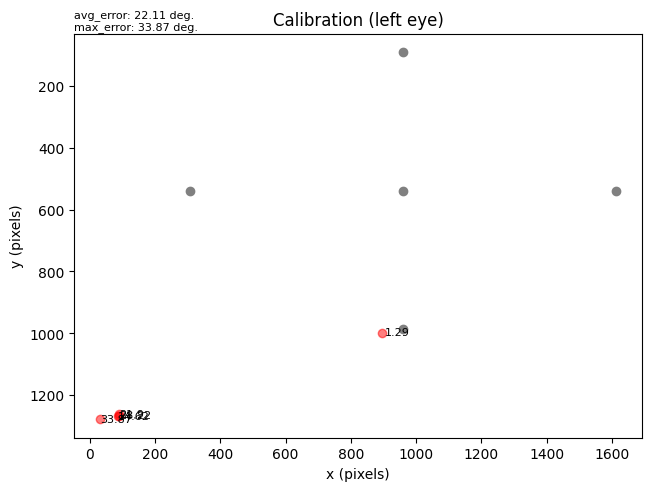

Processing subject: 1040M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1040M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1040M1_GO.asc
Number of calibrations for subject 1040M1: 1
Processing subject: 1040P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1040P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1040P_GO.asc
Number of calibrations for subject 1040P: 1
Processing subject: 1042F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1042F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1042F1_GO.asc
Number of calibrations for su

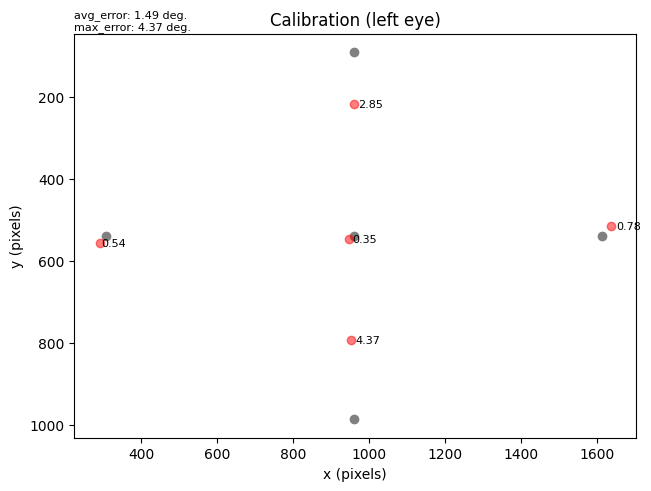

Processing subject: 1052M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1052M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1052M1_GO.asc
Number of calibrations for subject 1052M1: 1
Processing subject: 1052P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1052P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1052P_GO.asc
Error reading calibration data for subject 1052P: Could not find the start of the recording.
Processing subject: 1052S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1052S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_

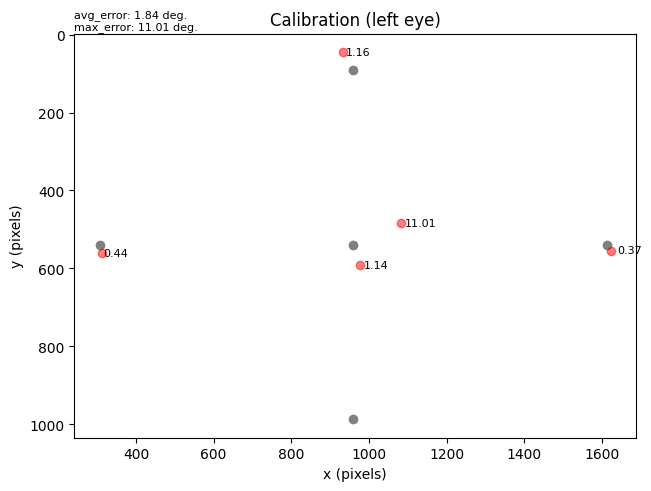

Processing subject: 1061F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1061F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1061F1_GO.asc
Number of calibrations for subject 1061F1: 1
Processing subject: 1061S3
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1061S3_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1061S3_GO.asc
Number of calibrations for subject 1061S3: 1
Processing subject: 1067M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1067M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1067M1_GO.asc
Number of calibrations fo

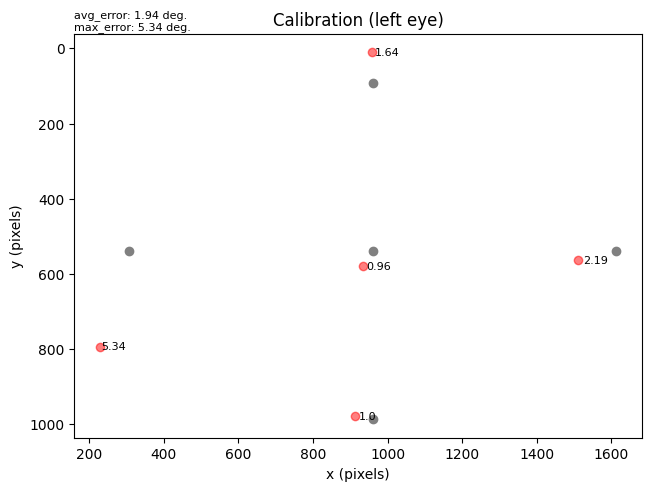

Processing subject: 1078F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1078F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1078F1_GO.asc
Number of calibrations for subject 1078F1: 1
Processing subject: 1078P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1078P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1078P_GO.asc
Number of calibrations for subject 1078P: 1
Processing subject: 1080F1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1080F1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1080F1_GO.asc
Number of calibrations for su

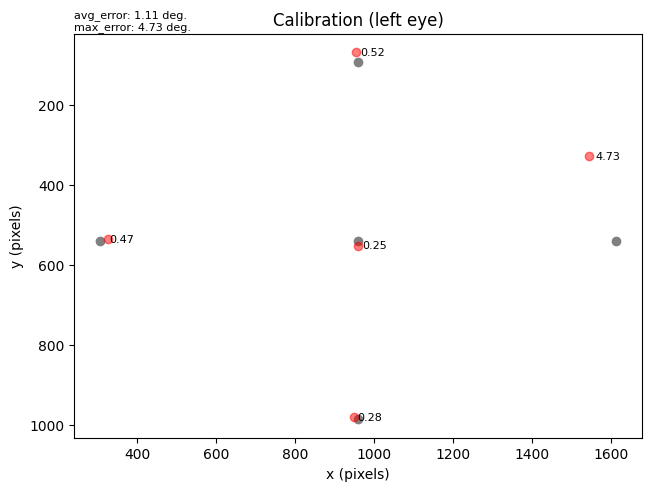

Processing subject: 1083P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1083P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1083P_GO.asc
Number of calibrations for subject 1083P: 1
Processing subject: 1083S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1083S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1083S1_GO.asc
Number of calibrations for subject 1083S1: 1
Processing subject: 1089M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1089M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1089M1_GO.asc
Error reading calibration dat

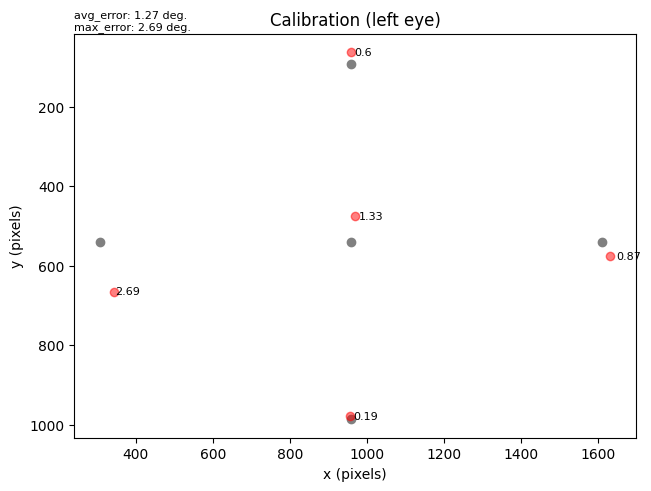

Processing subject: 1093S2
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1093S2_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1093S2_GO.asc
Number of calibrations for subject 1093S2: 1


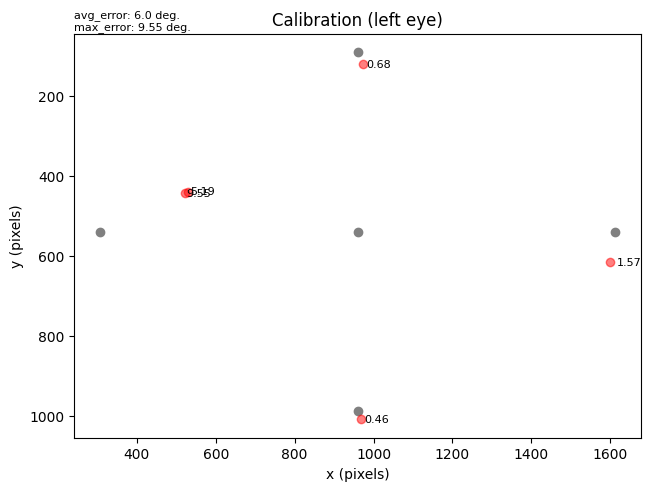

Processing subject: 1101P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1101P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1101P_GO.asc
Number of calibrations for subject 1101P: 1


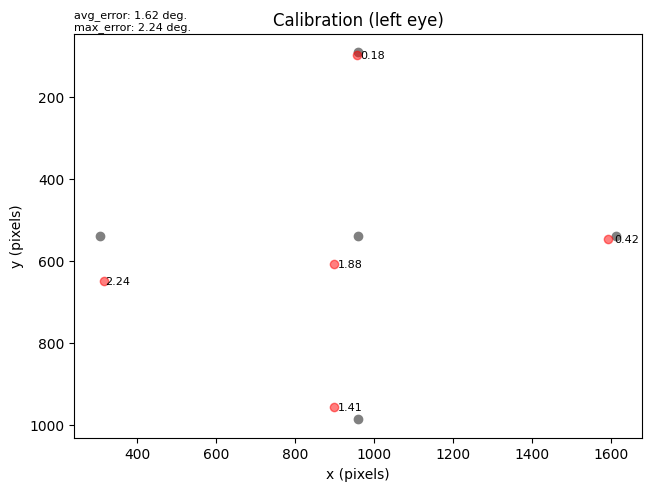

Processing subject: 1102P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1102P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1102P_GO.asc
Number of calibrations for subject 1102P: 1
Processing subject: 1102S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1102S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1102S1_GO.asc
Number of calibrations for subject 1102S1: 1
Processing subject: 1102S2
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1102S2_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1102S2_GO.asc
Number of calibrations for su

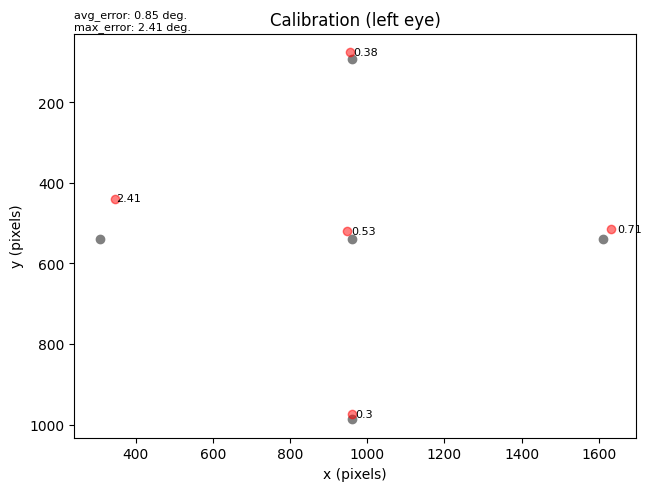

Processing subject: 1112M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1112M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1112M1_GO.asc
Number of calibrations for subject 1112M1: 1
Processing subject: 1112P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1112P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1112P_GO.asc
Number of calibrations for subject 1112P: 1
Processing subject: 1114P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1114P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1114P_GO.asc
Number of calibrations for subje

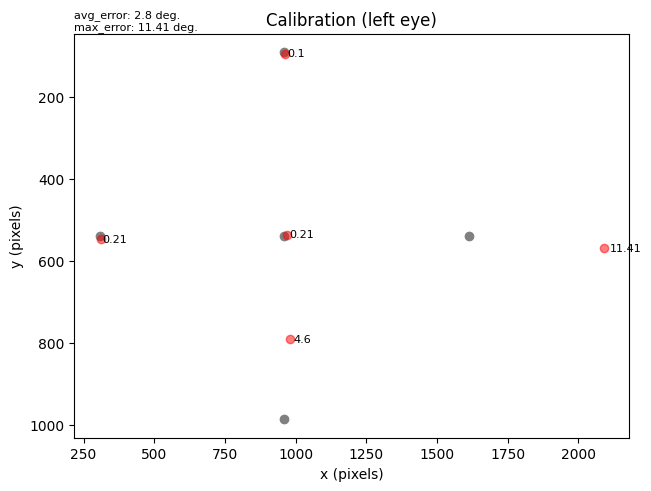

Processing subject: 1121M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1121M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1121M1_GO.asc
Number of calibrations for subject 1121M1: 1
Processing subject: 1121P
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1121P_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1121P_GO.asc
Number of calibrations for subject 1121P: 1
Processing subject: 1121S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1121S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1121S1_GO.asc
Number of calibrations for su

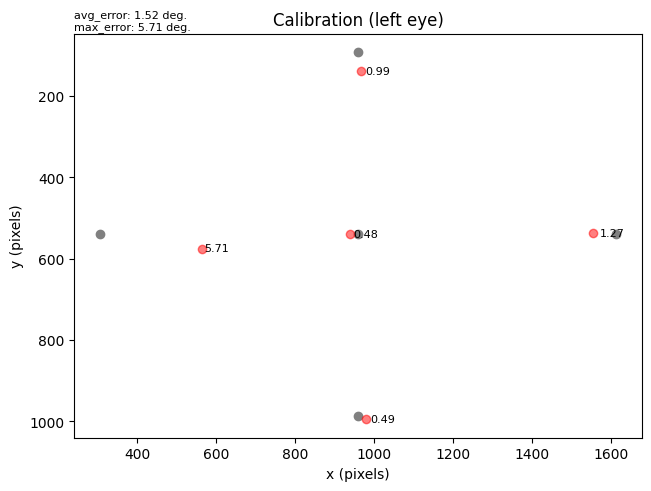

Processing subject: 1147S1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1147S1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1147S1_GO.asc
Number of calibrations for subject 1147S1: 1
Processing subject: 1147S2
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1147S2_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1147S2_GO.asc
Error reading calibration data for subject 1147S2: Could not find the start of the recording.
Processing subject: 1162M1
C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files\asc_files\1162M1_GO.asc
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\

,subject,n_calibrations,last_avg_error,last_max_error,calibration_quality
0,0042P,1,0.28,0.42,good
1,0043F1,1,0.36,0.97,good
2,0050M1,1,0.39,0.92,good
3,0050P,2,0.77,1.09,good
4,0062P,1,0.33,0.53,good
...,...,...,...,...,...
148,1143P,1,0.68,1.66,fair
149,1147F1,1,0.37,0.42,good
150,1147P,1,1.52,5.71,poor
151,1147S1,1,0.39,0.59,good


In [98]:
# Load the ASC files

# Create calibration dictionary with subject ID, average error, and max error
calibration_data = {}
missing_calibration = []
asc_files = glob.glob(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/*/*.asc", recursive=True)
for file in asc_files:
    # Get subject ID from the file name
    subject_id = file.split("\\")[-1].split("_")[0]
    print(f"Processing subject: {subject_id}")
    print(file)

    try: 
        # Read the calibration data from the file
        # This will raise an error if the file is not a valid Eyelink file
        cals = read_eyelink_calibration(file) 
    except Exception as e:
        print(f"Error reading calibration data for subject {subject_id}: {e}")
        missing_calibration.append(subject_id)
        continue
    
    # Print the number of calibrations
    print(f"Number of calibrations for subject {subject_id}: {len(cals)}")
          
    # If more than one calibration, print the file name
    if len(cals) > 1:
        print(f"Multiple calibrations found for subject {subject_id}. Using the last one.")

    # If no calibrations, skip the subject
    elif len(cals) == 0:
        print(f"No calibrations found for subject {subject_id}. Skipping.")
        missing_calibration.append(subject_id)
        calibration_data[subject_id] = {
            'n_calibrations': 0,
            "last_avg_error": None,
            "last_max_error": None,
            "calibration_quality": "missing"
        }   
        continue
    
    # Get the average error and max error from the last calibration 
    last_cal = cals[-1]
    # Get the average error
    last_avg_error = last_cal["avg_error"]
    # Get the max error
    last_max_error = last_cal["max_error"]  
          
    # Classify the calibration as good, fair or poor based on the average error and max error
    if last_avg_error < 1.0 and last_max_error < 1.5:
        calibration_quality = "good"
    elif last_avg_error < 1.5 and last_max_error < 2.1:
        calibration_quality = "fair"
    else:
        calibration_quality = "poor"
        
    # Plot the calibration data if the calibration is poor and save the plot
    if calibration_quality == "poor":
        # Plot the calibration data
        fig = last_cal.plot()
        # Set the title of the plot
        fig.suptitle(f"Calibration for subject {subject_id} - {calibration_quality} quality", fontsize=16)
                
        # Save the plot
        fig.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/calibration/poor/{subject_id}_calibration.png")
        plt.close(fig)
        
    # Add the data to the dictionary
    calibration_data[subject_id] = {
        'n_calibrations': len(cals),
        "last_avg_error": last_avg_error,
        "last_max_error": last_max_error,
        "calibration_quality": calibration_quality,
    }

# Convert the dictionary to a dataframe with subject, and avg_error and max_error as columns
calibration_df = pd.DataFrame.from_dict(calibration_data, orient="index").reset_index()
calibration_df.rename(columns={"index": "subject"}, inplace=True)

calibration_df

In [99]:
# Add section to the document
doc.add_heading('Calibration Data', level=1)
# Add the calibration data to the document
doc.add_paragraph("Calibration data for each subject is summarized below. The average error and maximum error are used to classify the calibration quality as good, fair, or poor.")
doc.add_paragraph(
    "The average error is the mean of the errors across all calibration points, while the maximum error is the largest error observed at any calibration point. "
    "The calibration quality is determined based on the following criteria:\n\n"
    "1. Good: Average error < 1.0° and Max error < 1.5°\n"
    "2. Fair: Average error < 1.5° and Max error < 2.0°\n"
    "3. Poor: Average error >= 1.5° or Max error >= 2.0°\n\n"
    "The calibration quality is used to determine if the subject's data should be included in the analysis.\n\n"
    "Note: Subjects with poor calibration quality are excluded from the analysis."
)
# Add to doc and then print for notebook 
doc.add_paragraph(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}", style='ListBullet')
# Print total number of subjects with calibration data
print(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}")
# Add total number of subjects with good calibration
doc.add_paragraph(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}", style='ListBullet')
# Print total number of subjects with good calibration
print(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}")
# Add total number of subjects with fair calibration
doc.add_paragraph(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}", style='ListBullet')
# Print total number of subjects with fair calibration
print(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}")
# Add total number of subjects with poor calibration
doc.add_paragraph(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}", style='ListBullet')
# Print total number of subjects with poor calibration
print(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}")


Total number of subjects with calibration data: 153
Total number of subjects with good calibration: 121
Total number of subjects with fair calibration: 13
Total number of subjects with poor calibration: 15


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [100]:
# Add subject with poor calibration to subjects_removed_df
missing_ids = calibration_df[calibration_df["calibration_quality"] == "poor"][["subject"]].copy()
# Add the subjects with poor calibration to subjects_removed_df and add reasons as 'poor calibration'
missing_ids["status"] = "poor calibration"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)
# Print subjects removed due to poor calibration
print(f"Total number of subjects removed due to poor calibration: {len(subjects_removed_df[subjects_removed_df['status'] == 'poor calibration'])}")
subjects_removed_df

Total number of subjects removed due to poor calibration: 15


,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [101]:
# Check for duplicates in the subjects removed df
duplicates = subjects_removed_df[subjects_removed_df.duplicated(subset=["subject"], keep=False)]

# If duplicates found, append their values in status together in the status column
if len(duplicates) > 0:
    # Group by subject and concatenate the status values
    grouped = duplicates.groupby("subject")["status"].apply(lambda x: ", ".join(x)).reset_index()
    # Merge the grouped data back into the original dataframe
    subjects_removed_df = subjects_removed_df.drop_duplicates(subset=["subject"]).merge(grouped, on="subject", how="left", suffixes=("", "_new"))
    # Update the status column with the concatenated values
    subjects_removed_df["status"] = subjects_removed_df["status_new"].fillna(subjects_removed_df["status"])
    subjects_removed_df = subjects_removed_df.drop(columns=["status_new"])
    
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [102]:
# Add column to go_df that flags subjects with enough trials

go_df["min_ntrials"] = go_df["subject"].isin(trial_data[trial_data["valid_trials_all_conditions"] == True]["subject"])

# Add column of calibration quality
go_df = go_df.merge(calibration_df[["subject", "calibration_quality"]], on="subject", how="left")

go_df


,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN


In [103]:
# Save go_df with the new column
go_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv", index=False)

In [104]:
# Save the subjects removed df
subjects_removed_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv", index=False)

### Demographics of Excluded Participants

Analyze the demographic characteristics of participants who were excluded during preprocessing.

In [105]:
# Select only subjects without min trials or poor calibration

demo_df = go_df [(go_df["min_ntrials"] == False) | (go_df["calibration_quality"]== "poor")]

# Select only the first row per participant
demo_df = demo_df.drop_duplicates(subset=["subject"], keep="first")
demo_df

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality
500,0083F1,1,Overlap,Right,543.72,True,45.95,hsj,male,1.0,ndd,Q1K_HSJ_10083_F1,father,adult,True,poor
536,0083M1,1,Baseline,Left,NaN,False,40.95,hsj,female,NaN,ndd,Q1K_HSJ_10083_M1,mother,adult,False,good
1470,0147M1,1,Gap,Right,NaN,False,38.52,hsj,female,NaN,ndd,Q1K_HSJ_100147_M1,mother,adult,False,good
1582,0150M1,1,Gap,Left,NaN,False,37.90,hsj,female,NaN,ndd,Q1K_HSJ_100150_M1,mother,adult,False,good
1620,0152M1,1,Gap,Left,NaN,False,43.54,hsj,female,NaN,no_ndd,Q1K_HSJ_100152_M1,mother,adult,False,fair
1630,0154P,0,Gap,Left,NaN,False,3.28,hsj,male,NaN,ndd,Q1K_HSJ_100154_P,proband,child,False,NaN
2159,0181P,1,Baseline,Right,306.99,True,20.14,mni,male,0.0,ndd,Q1K_MHC_200181_P,proband,adult,False,poor
2749,0216P,1,Baseline,Right,190.26,True,14.43,mni,female,NaN,ndd,Q1K_MHC_200216_P,proband,child,False,good
3126,0248S1,1,Gap,Right,NaN,False,11.78,mni,male,NaN,ndd,Q1K_MHC_200248_S1,sibling,child,False,good
3240,0265P,1,Overlap,Right,NaN,False,13.23,mni,male,NaN,ndd,Q1K_MHC_200265_P,proband,child,True,poor


In [106]:
# Summarize data by diagnosis groups
summary_table = demo_df.groupby("ndd").agg(
    n=("ndd", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("eeg_age", "mean"),
    std_age=("eeg_age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "ndd": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df["eeg_age"].mean(),
    "std_age": demo_df["eeg_age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "ndd": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)

In [107]:
summary_table=summary_table.round(2)
summary_table

,NDD Group,Total Participants,Mean Age,Age SD,Adults,Children,sex (M:F),sex % (M:F),site (HSJ:MNI),site % (HSJ:MNI)
0,combined,32,23.69,17.10,15,17,22:10,68.75:31.25,28:4,87.5:12.5
1,ndd,23,21.71,16.54,10,13,17:6,73.91:26.09,19:4,82.61:17.39
2,no_ndd,9,28.78,18.42,5,4,5:4,55.56:44.44,9:0,100.0:0.0


In [108]:
## Add table to the document
doc.add_heading('Demographics Breakdown of Excluded Participants', level=1)

# Add total participants before and after preprocessing
doc.add_paragraph(
    f"Total number of participants before preprocessing: {len(go_df['subject'].unique())}",
    style='ListBullet'
)
# Add total participants removed due to preprocessing in red font
doc.add_paragraph(
    f"Total number removed due to preprocessing: {len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(255, 0, 0)  

# Add total participants after preprocessing in green font
doc.add_paragraph(
    f"Total number of participants after preprocessing: {len(go_df['subject'].unique()) - len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(0, 128, 0)

doc.add_heading('Demographics Table', level=3)

doc = df_to_table(doc, summary_table)


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [109]:
# Save the document as a copy with dat to archive 
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/archive/gap_et_preprocessing_results_{date}.docx")
# Print the path to the saved document
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/gap_et_preprocessing_results.docx")